# Data handling and cleaning

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# global variables
DATA_PATH = r"../data/yellow_tripdata_2020-01.csv"
SHP_INPUT_PATH = r"../data/taxi_zones/taxi_zone_censo.shp"
COLUMNS_TO_DROP = [
    'VendorID',
    'RatecodeID',
    'store_and_fwd_flag',
    'payment_type',
    'fare_amount',
    'extra',
    'mta_tax',
    'tip_amount',
    'tolls_amount',
    'improvement_surcharge', 
    'congestion_surcharge'
]
OUTSHP_DIR = r"../output/2020-01.shp"

In [3]:
# important: all functions assume, in some manner, the dataset's data structure
# scripts do João Arthur
def read_data(path=None):
    """
    Reads the input CSV data to a dataframe.
    :path: (str) path to a custom data source.
    :return: (pandas.DataFrame) all input data.
    """
    return pd.read_csv(path or DATA_PATH)

def format_date_column(df, col_pu, col_do, col_dow, col_hour, col_period, col_duration):
    """
    Formats timestamp column to date and type columns.
    :param df: (pandas.DataFrame) dataset to have its timestamp column expanded to date and time columns.
    :param col_pu: (str) input column name for pickup timestamp data.
    :param col_do: (str) input column name for dropoff timestamp data.
    :param col_dow: (str) column name for newly added day of the week column.
    :param col_hour: (str) column name for newly added hour column.
    :param col_period: (str) column name for newly added hour period of the day.
    :param col_duration: (str) column name for newly added hour period of the day, in minutes.
    :return: (pandas.DataFrame) dataset with date and time columns.
    """
    datetime_col_pu = pd.to_datetime(df[col_pu]).dt
    df[col_dow] = datetime_col_pu.day_name()
    df[col_hour] = datetime_col_pu.hour
    df[col_period] = pd.cut(
        datetime_col_pu.hour,
        bins=[-.1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
        labels=["0-2", "2-4", "4-8", "8-10", "10-12", "12-14", "14-16", "16-18", "18-20", "20-22", "22-24"]
    )
    df['total_time'] = (pd.to_datetime(df[col_do]) - pd.to_datetime(df[col_pu])).dt.total_seconds() / 60.
    return df

def setup_data(df, columns_to_drop=None):
    """
    Reads the input CSV data to a dataframe.
    :param df: (pandas.DataFrame) dataset to be cleaned.
    :param columns_to_drop: (list-of-str) list of columns to be dropped.
    :return: (pandas.DataFrame) cleaned up dataset.
    """
    df = format_date_column(df, "tpep_pickup_datetime", "tpep_dropoff_datetime", "pu_dow", "pu_hour", "pu_period", "total_time")
    df["clean_price"] = df['total_amount'] - df['improvement_surcharge']\
                        - df['congestion_surcharge'] - df['tolls_amount'] - df['mta_tax']
    df["target"] = df["total_amount"] / (df["trip_distance"] * df["total_time"])
    df = df.drop(columns_to_drop or COLUMNS_TO_DROP, axis=1)
    return df

def read_shape(path=None):
    """
    Reads the shapefile containing localtion polygons.
    :return: (geopandas.GeoDataFrame) data frame for the location shapefile data.
    """
    return gpd.read_file(path or SHP_INPUT_PATH)


In [4]:
df = read_data()

/Users/joao/Documents/Projetos/jpesperidiao/EstatisticaEspacial-MBA_FGV_T5/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
df1 = setup_data(df)
drop_cols = [
    'tpep_pickup_datetime',
    'tpep_dropoff_datetime',
    'passenger_count',
    'DOLocationID',
    'total_amount',
    'pu_hour'
]
df1 = df1.drop(drop_cols, axis=1)
df1 = df1[df1["trip_distance"] > 0]
df1 = df1[df1["total_time"] > 0]

In [6]:
df2 = df1.groupby("PULocationID").agg({"target": "mean"}).reset_index("PULocationID")
df2.columns

Index(['PULocationID', 'target'], dtype='object')

<AxesSubplot:>

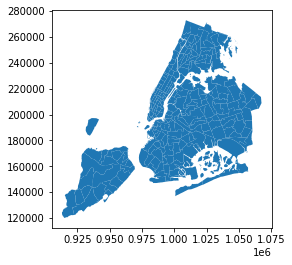

In [7]:
shp = read_shape()
shp = shp.set_index("OBJECTID")
shp.plot()

In [8]:
outshp = shp.merge(df2, left_on="LocationID", right_on="PULocationID", how="left")

In [9]:
outshp.to_file(OUTSHP_DIR)